# **1. Import the necessary libraries, load the dataset, and prepare the data for analysis**

In [1]:
# Import necessary libraries
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Read the data
df = pd.read_csv('Retail_Data_Transactions.csv', parse_dates=['trans_date'])

In [3]:
# Identify the time range studied
print(df['trans_date'].min(), df['trans_date'].max())

2011-05-16 00:00:00 2015-03-16 00:00:00


In [4]:
# Calculate the number of days between the study date and each transaction date
sd = dt.datetime(2015,4,1)
df['hist'] = sd - df['trans_date']
df['hist'].astype('timedelta64[D]')
df['hist'] = df['hist'] / np.timedelta64(1, 'D')

In [5]:
# Filter the dataset to only consider transactions from the last 2 years
df = df[df['hist'] < 730]

# **2. RFM Analysis**

In [6]:
# Calculate recency, frequency, and monetary value for each customer
rfmTable = df.groupby('customer_id').agg({'hist': lambda x:x.min(), # Recency
                                        'customer_id': lambda x: len(x),               # Frequency
                                        'tran_amount': lambda x: x.sum()})          # Monetary Value

rfmTable.rename(columns={'hist': 'recency', 
                         'customer_id': 'frequency', 
                         'tran_amount': 'monetary_value'}, inplace=True)

In [7]:
# Categorize customers based on quartiles
quartiles = rfmTable.quantile(q=[0.25,0.50,0.75])
quartiles = quartiles.to_dict()

def RClass(x,p,d):
    if x <= d[p][0.25]:
        return 1
    elif x <= d[p][0.50]:
        return 2
    elif x <= d[p][0.75]: 
        return 3
    else:
        return 4
    
def FMClass(x,p,d):
    if x <= d[p][0.25]:
        return 4
    elif x <= d[p][0.50]:
        return 3
    elif x <= d[p][0.75]: 
        return 2
    else:
        return 1

rfmSeg = rfmTable
rfmSeg['R_Quartile'] = rfmSeg['recency'].apply(RClass, args=('recency',quartiles,))
rfmSeg['F_Quartile'] = rfmSeg['frequency'].apply(FMClass, args=('frequency',quartiles,))
rfmSeg['M_Quartile'] = rfmSeg['monetary_value'].apply(FMClass, args=('monetary_value',quartiles,))

# Create a combined score for each customer
rfmSeg['RFMClass'] = rfmSeg.R_Quartile.map(str) + rfmSeg.F_Quartile.map(str) + rfmSeg.M_Quartile.map(str)
rfmSeg.sort_values(by=['RFMClass', 'monetary_value'], ascending=[True, False])

rfmSeg['Total Score'] = rfmSeg['R_Quartile'] + rfmSeg['F_Quartile'] +rfmSeg['M_Quartile']

In [8]:
# Analyze the impact of RFM analysis on customer response to a promotional campaign
res = pd.read_csv('Retail_Data_Response.csv')
res.sort_values('customer_id', inplace=True)
rfmSeg.reset_index(inplace=True)
rfmSeg.sort_values('customer_id', inplace=True)
rfm2=pd.merge(rfmSeg, res, on='customer_id')

# **3. Data Visualization**

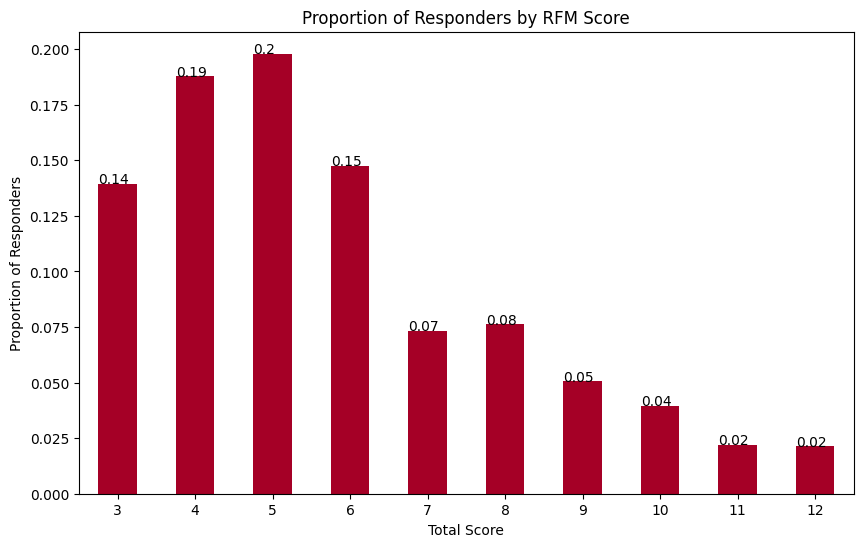

In [9]:
# Plot the proportion of responders for each score
ax = rfm2.groupby('Total Score').agg('response').mean().plot(kind='bar', colormap='RdYlGn')
ax.set_xlabel("Total Score")
ax.set_ylabel("Proportion of Responders")
ax.set_title("Proportion of Responders by RFM Score")

# Add data labels to the bars
for i in ax.patches:
    ax.annotate(str(round(i.get_height(), 2)), (i.get_x(), i.get_height()))

# Rotate x-axis labels
plt.xticks(rotation=0)

# Adjust figure size
fig = plt.gcf()
fig.set_size_inches(10, 6)

# Display the chart
plt.show()